<a href="https://colab.research.google.com/github/anastasiia-vsk/ML_course/blob/main/HW_NLP_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.



In [57]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.

In [2]:
path = '/content/tweet_sentiment_train.csv.zip'
raw_df = pd.read_csv(path)

In [3]:
raw_df.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [9]:
rows, cols = raw_df.shape
print(f"Кількість рядків: {rows}")
print(f"Кількість стовпців: {cols}")

Кількість рядків: 27481
Кількість стовпців: 4


In [10]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [12]:
raw_df.isnull().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0


In [13]:
raw_df[raw_df.isnull().any(axis=1)]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


In [17]:
raw_df = raw_df.dropna()
raw_df.shape # перевірка

(27480, 4)

### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [19]:
raw_df.sentiment.value_counts(normalize=True)

,proportion
sentiment,
neutral,0.404549
positive,0.312300
negative,0.283151


Спостереження:
- Клас "neutral", що становить понад 40% усіх постів. Класи "positive" і "negative" зустрічаються приблизно однаково часто, але все ж трохи переважає "positive".
- Класи не ідеально збалансовані, але великого перекосу немає.



In [20]:
raw_df['text_length'] = raw_df['text'].str.len()

In [27]:
raw_df['text_length'].describe()

,text_length
count,27480.000000
mean,68.330022
std,35.603870
min,3.000000
25%,39.000000
50%,64.000000
75%,97.000000
max,141.000000


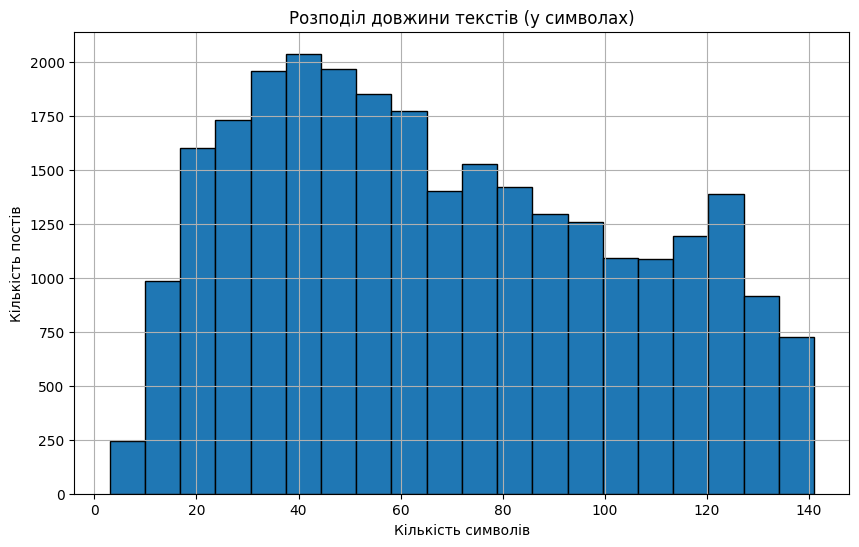

In [28]:
plt.figure(figsize=(10, 6))
plt.hist(raw_df['text_length'], bins=20, edgecolor='black')
plt.title('Розподіл довжини текстів (у символах)')
plt.xlabel('Кількість символів')
plt.ylabel('Кількість постів')
plt.grid(True)
plt.show()

Спостереження:
- Більшість постів — короткі, у діапазоні 20–70 символів.
- Максимальне значення 141 символ — пов’язане з обмеженням платформи (Twitter у минулому мав ліміт у 140 символів).
- Видимі піки у діапазонах 30–50, 70–80, 120–130 символів можуть говорити про різні стилі взаємодії користувачів. Можливо, є різні типи постів: короткі репліки, середньої довжини коментарі та максимально довгі "впритик ліміту у 140 символів".

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [32]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
stemmer = SnowballStemmer("english")

In [34]:
def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'[^a-z\s]', '', text)

    tokens = text.split()

    processed_tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]

    return ' '.join(processed_tokens)

In [35]:
raw_df['clean_text'] = raw_df['text'].apply(lambda x: preprocess_text(str(x)))

In [36]:
raw_df.head(5)

,textID,text,selected_text,sentiment,text_length,clean_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,36,id respond go
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,46,sooo sad miss san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,25,boss bulli
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31,interview leav alon
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,75,son couldnt put releas alreadi bought


In [39]:
from collections import Counter

all_words = ' '.join(raw_df['clean_text']).split()
word_freq = Counter(all_words)
print(f"Унікальних слів: {len(word_freq)}")

word_freq.most_common(30)

Унікальних слів: 22764


[('im', 3059),
 ('day', 2414),
 ('go', 2363),
 ('get', 1909),
 ('good', 1569),
 ('work', 1483),
 ('love', 1458),
 ('like', 1454),
 ('dont', 1202),
 ('today', 1115),
 ('got', 1087),
 ('time', 1079),
 ('one', 1055),
 ('cant', 1030),
 ('happi', 993),
 ('want', 983),
 ('know', 969),
 ('thank', 962),
 ('miss', 961),
 ('lol', 953),
 ('u', 931),
 ('realli', 909),
 ('back', 897),
 ('see', 893),
 ('think', 875),
 ('feel', 869),
 ('mother', 788),
 ('night', 785),
 ('hope', 782),
 ('make', 752)]

In [40]:
vectorizer = CountVectorizer(max_features=5000)

In [44]:
X_bow = vectorizer.fit_transform(raw_df['clean_text'])


bow_df = pd.DataFrame(X_bow.toarray(), columns=vectorizer.get_feature_names_out())
bow_df.head()

,aaaah,aaah,aah,aaron,ab,abandon,abbi,abc,abil,abit,...,zach,zack,ze,zealand,zelda,zero,zoe,zombi,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [79]:
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, raw_df['sentiment'], test_size=0.2, stratify=raw_df['sentiment'], random_state=42)

In [48]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier()
}

for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train_bow, y_train)
    y_pred = model.predict(X_test_bow)
    print(classification_report(y_test, y_pred))


Logistic Regression
              precision    recall  f1-score   support

    negative       0.70      0.63      0.66      1556
     neutral       0.63      0.72      0.67      2223
    positive       0.76      0.70      0.73      1717

    accuracy                           0.69      5496
   macro avg       0.70      0.68      0.69      5496
weighted avg       0.69      0.69      0.69      5496


Decision Tree
              precision    recall  f1-score   support

    negative       0.59      0.63      0.61      1556
     neutral       0.62      0.59      0.60      2223
    positive       0.69      0.68      0.68      1717

    accuracy                           0.63      5496
   macro avg       0.63      0.63      0.63      5496
weighted avg       0.63      0.63      0.63      5496


Random Forest
              precision    recall  f1-score   support

    negative       0.69      0.64      0.66      1556
     neutral       0.66      0.68      0.67      2223
    positive       0.73 

<Figure size 500x400 with 0 Axes>

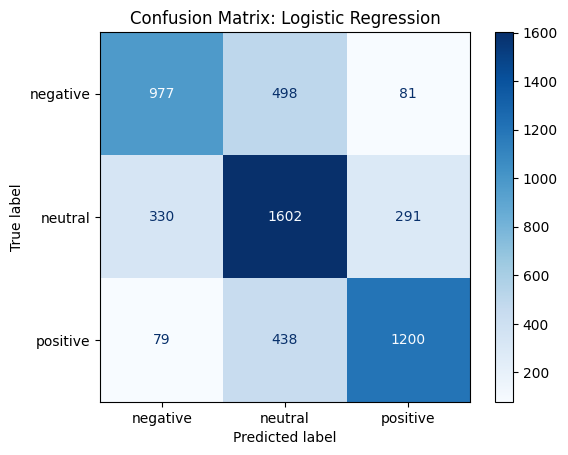

<Figure size 500x400 with 0 Axes>

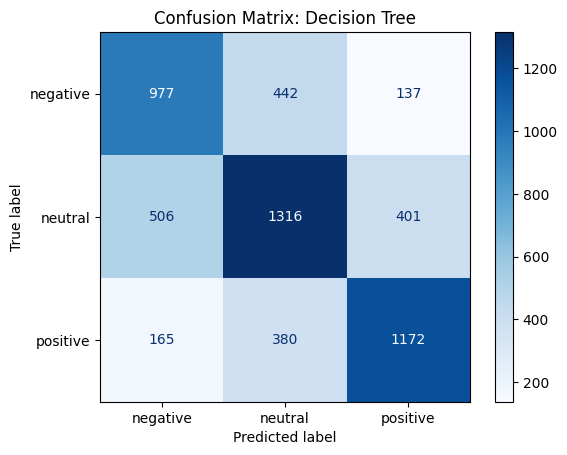

<Figure size 500x400 with 0 Axes>

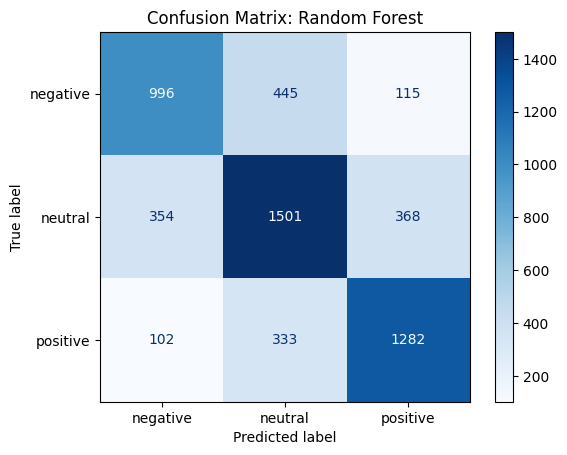

<Figure size 500x400 with 0 Axes>

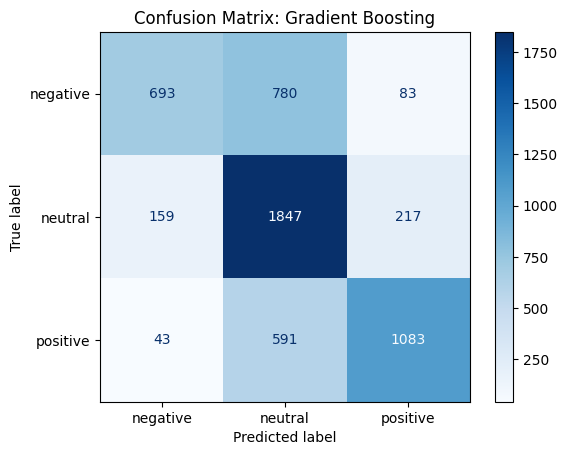

In [50]:
for model_name in ["Logistic Regression", "Decision Tree", "Random Forest", "Gradient Boosting"]:
    model = models[model_name]
    y_pred = model.predict(X_test_bow)

    cm = confusion_matrix(y_test, y_pred, labels=["negative", "neutral", "positive"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"])

    plt.figure(figsize=(5, 4))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.grid(False)
    plt.show()

**Logistic Regression:**
Найстабільніший результат. Добре справляється з усіма класами. Високий precision і f1 для positive, трохи слабше на negative. Часто плутає negative ↔ neutral.

**Random Forest:**
Дуже схожий результат до логістичної. Часто плутає neutral з negative/positive, але менш ніж Logistic Regression.

**Gradient Boosting:**
Високий precision на negative, але дуже низький recall - часто не вгадує негативні пости. Дуже часто помилково класифікує negative як neutral.
Потребує тюнінгу гіперпараметрів.

**Decision Tree:**
Метрики непогані, але серед усіх моделей найгірші. Часто плутає neutral з обома іншими класами.



### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [53]:
# Logistic Regression
feature_names = vectorizer.get_feature_names_out()

coefs = models["Logistic Regression"].coef_

classes = models["Logistic Regression"].classes_

# Аналіз: для кожного класу топ-15 найвпливовіших слів
for i, class_label in enumerate(classes):
    top_positive = np.argsort(coefs[i])[-15:]
    top_negative = np.argsort(coefs[i])[:15]

    print(f"\nКлас '{class_label}' — слова з найбільшим впливом на прогноз:")

    print("Найсильніші позитивні (підвищують ймовірність цього класу):")
    for idx in reversed(top_positive):
        print(f"{feature_names[idx]}: {coefs[i][idx]:.3f}")

    print("\nНайсильніші негативні (зменшують ймовірність цього класу):")
    for idx in top_negative:
        print(f"{feature_names[idx]}: {coefs[i][idx]:.3f}")


Клас 'negative' — слова з найбільшим впливом на прогноз:
Найсильніші позитивні (підвищують ймовірність цього класу):
sad: 2.631
suck: 2.527
bore: 2.346
sorri: 2.331
hate: 2.254
fail: 2.116
miss: 2.106
stupid: 2.078
worst: 2.051
exhaust: 2.046
shame: 1.991
headach: 1.972
terribl: 1.955
unfortun: 1.923
horribl: 1.915

Найсильніші негативні (зменшують ймовірність цього класу):
awesom: -2.309
glad: -2.307
love: -2.152
beauti: -2.053
thank: -1.950
cute: -1.889
welcom: -1.719
amaz: -1.656
enjoy: -1.638
great: -1.560
fine: -1.503
nice: -1.479
hope: -1.463
yum: -1.454
bless: -1.366

Клас 'neutral' — слова з найбільшим впливом на прогноз:
Найсильніші позитивні (підвищують ймовірність цього класу):
indoor: 1.548
how: 1.365
otherwis: 1.329
oooo: 1.182
parvo: 1.136
starwarsday: 1.125
sp: 1.103
twhirl: 1.086
colorado: 1.062
httptwitpiccomhac: 1.062
moro: 1.047
satisfi: 1.040
mb: 1.030
becki: 1.016
pfft: 1.016

Найсильніші негативні (зменшують ймовірність цього класу):
forum: -1.367
product: -1.316

**Спостереження:** модель логістичної регресії показує логічну поведінку: для класу negative вона найсильніше реагує на слова з негативним забарвленням (sad, suck, fail, hate), для positive — на явно позитивну лексику (awesom, love, thank, great). Клас neutral найменш виражений, і модель інтерпретує його як відсутність емоцій — активізується на загальних або технічних словах. ***Загалом впливові слова відповідають очікуванням.***

In [55]:
# Random Forest
importances = models["Random Forest"].feature_importances_
indices = np.argsort(importances)[-15:]

print("Найважливіші слова для Random Forest:")
for idx in reversed(indices):
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")

Найважливіші слова для Random Forest:
love: 0.0260
thank: 0.0216
good: 0.0174
happi: 0.0147
miss: 0.0146
sad: 0.0125
great: 0.0095
sorri: 0.0084
hate: 0.0080
hope: 0.0080
nice: 0.0079
mother: 0.0069
awesom: 0.0067
suck: 0.0066
fun: 0.0065


**Спостереження:** модель Random Forest як найважливіші ознаки виділяє слова з сильним емоційним забарвленням — як позитивним (love, thank, good, happi), так і негативним (sad, sorri, hate, suck)

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.

In [58]:
raw_df.head()
# препроцесинг був виконаний для всього датасету

,textID,text,selected_text,sentiment,text_length,clean_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,36,id respond go
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,46,sooo sad miss san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,25,boss bulli
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31,interview leav alon
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,75,son couldnt put releas alreadi bought


In [68]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(raw_df['clean_text'])

X_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 170059 stored elements and shape (27480, 5000)>

In [69]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, raw_df['sentiment'], test_size=0.2, stratify=raw_df['sentiment'], random_state=42)

In [70]:
# використала логістичну регресію

lr_tfidf = LogisticRegression(max_iter=1000)
lr_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)

In [71]:
print(classification_report(y_test, y_pred_tfidf))

              precision    recall  f1-score   support

    negative       0.73      0.61      0.66      1556
     neutral       0.62      0.75      0.68      2223
    positive       0.78      0.68      0.73      1717

    accuracy                           0.69      5496
   macro avg       0.71      0.68      0.69      5496
weighted avg       0.70      0.69      0.69      5496



<Figure size 500x400 with 0 Axes>

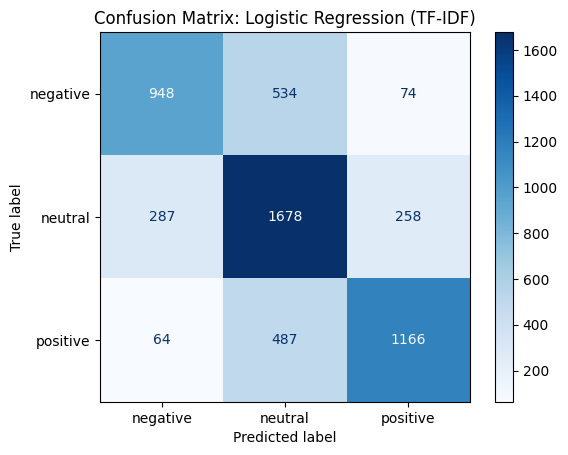

In [72]:
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf, labels=["negative", "neutral", "positive"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf, display_labels=["negative", "neutral", "positive"])

plt.figure(figsize=(5, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix: Logistic Regression (TF-IDF)")
plt.grid(False)
plt.show()

**Спостереження:**
Якість класифікації залишилась стабільною — accuracy 0.69, F1 ~0.69 (на рівні з BoW).

TF-IDF краще витягує клас neutral — recall підвищився до 0.75.
Найкраще передбачення має positive — як precision (0.78), так і F1 (0.73).

In [74]:
feature_names = tfidf_vectorizer.get_feature_names_out()

coefs = lr_tfidf.coef_
classes = lr_tfidf.classes_

for i, class_label in enumerate(classes):
    print(f"\nКлас '{class_label}' — найвпливовіші слова (TF-IDF):")

    top_pos = np.argsort(coefs[i])[-15:]
    print("Найсильніші позитивні (підвищують ймовірність цього класу):")
    for idx in reversed(top_pos):
        print(f"{feature_names[idx]}: {coefs[i][idx]:.3f}")

    top_neg = np.argsort(coefs[i])[:15]
    print("\nНайсильніші негативні (зменшують ймовірність цього класу):")
    for idx in top_neg:
        print(f"{feature_names[idx]}: {coefs[i][idx]:.3f}")


Клас 'negative' — найвпливовіші слова (TF-IDF):
Найсильніші позитивні (підвищують ймовірність цього класу):
sad: 5.147
miss: 4.900
sorri: 4.511
suck: 4.390
hate: 4.345
bore: 3.869
fail: 3.634
hurt: 3.476
stupid: 3.393
tire: 3.255
sick: 3.244
poor: 3.150
bad: 3.053
headach: 2.964
worst: 2.656

Найсильніші негативні (зменшують ймовірність цього класу):
love: -5.078
thank: -3.746
awesom: -3.367
hope: -3.297
glad: -3.062
great: -2.817
nice: -2.487
cute: -2.283
enjoy: -2.272
amaz: -2.266
beauti: -2.071
welcom: -2.069
better: -2.042
excit: -1.969
best: -1.930

Клас 'neutral' — найвпливовіші слова (TF-IDF):
Найсильніші позитивні (підвищують ймовірність цього класу):
how: 1.796
guitar: 1.221
indoor: 1.202
moro: 1.077
differ: 0.988
except: 0.975
notic: 0.970
sent: 0.962
otherwis: 0.959
relat: 0.952
starwarsday: 0.950
jst: 0.934
tho: 0.920
werent: 0.908
insur: 0.894

Найсильніші негативні (зменшують ймовірність цього класу):
happi: -2.636
good: -2.539
fail: -1.953
stupid: -1.944
thank: -1.921
e

**Спостереження:**
- TF-IDF має різкіші ваги (наприклад, sad: 5.1 vs 2.6, love: 6.63 vs 2.4) та додає нові.

Для фінальної імплементації багатокласової класифікації сентименту краще обрати TF-IDF векторизацію, оскільки вона забезпечує більш точне відображення емоційного змісту тексту. Завдяки врахуванню не лише частоти слів, а й їхньої унікальності, TF-IDF краще розрізняє нюанси між класами — зокрема, ефективніше відділяє positive від neutral.
Крім того, TF-IDF автоматично знижує вагу часто вживаних, але малозначущих слів, зменшуючи вплив "шуму", притаманного BoW.

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [87]:
raw_df.dtypes

,0
textID,object
text,object
selected_text,object
sentiment,object
text_length,int64
clean_text,object


In [84]:
pd.set_option('display.max_colwidth', None)

errors_df = raw_df.loc[y_test.index].copy()
errors_df['predicted'] = y_pred_tfidf
errors_df['true'] = y_test

errors_df = errors_df[errors_df['predicted'] != errors_df['true']]
errors_df[['text', 'true', 'predicted']].head(20)

,text,true,predicted
23414,Reading and taking notes but undertanding none of it ... HELP!,negative,neutral
24609,"wow this morning 8.15 hrs ding dong breakfastservice, was a surprise of Marjoleine, Guido and Dirk for mothersday.Mother hapy, father too",positive,neutral
4127,Hoping that this will just heal on it`s own because anything I put on it just makes it worse. Owww,neutral,negative
20627,i`m just sooo in love....i think,positive,neutral
4832,yum. Do you do home delivery,positive,neutral
19360,Having a wonderful piece of cake for lunch - what else could I want???,positive,neutral
24967,"Don`t worry, you`ll get your stamina back soon What kind of distances do you run usually?",positive,neutral
10652,shack idol today(: can`t wait. it`s gonna be funnn poor cameron. he fell ON A BAR in speech today. i felt so bad for him,neutral,negative
17484,"Awww, *hugs* I wish I could help.",negative,positive
10247,Youtube isn`t working...and I wanted to watch Britains Got Talent. I`m debating about having a pity party.,negative,neutral


In [85]:
errors_df.groupby(['true', 'predicted']).size()

true      predicted
negative  neutral      534
          positive      74
neutral   negative     287
          positive     258
positive  negative      64
          neutral      487
dtype: int64

In [88]:
correct_df = raw_df.loc[y_test.index].copy()
correct_df['predicted'] = y_pred_tfidf
correct_df['true'] = y_test
correct_df = correct_df[correct_df['predicted'] == correct_df['true']]

In [89]:
text_column = 'clean_text' if 'clean_text' in raw_df.columns else 'text'

In [90]:
errors_texts = errors_df[text_column]
correct_texts = correct_df[text_column]

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_errors = vectorizer.fit_transform(errors_texts)
X_correct = vectorizer.transform(correct_texts)

mean_tfidf_errors = np.asarray(X_errors.mean(axis=0)).flatten()
mean_tfidf_correct = np.asarray(X_correct.mean(axis=0)).flatten()

# Різниця важливості
diff = mean_tfidf_errors - mean_tfidf_correct
top_indices = np.argsort(diff)[-20:]

In [91]:
top_words = np.array(vectorizer.get_feature_names_out())[top_indices]
top_diffs = diff[top_indices]

top_df = pd.DataFrame({
    'word': top_words,
    'tfidf_diff_errors_vs_correct': top_diffs
}).sort_values(by='tfidf_diff_errors_vs_correct', ascending=False)

top_df

,word,tfidf_diff_errors_vs_correct
19,wish,0.005010
18,help,0.003044
17,ok,0.002883
16,kind,0.002692
15,like,0.002622
14,talk,0.002503
13,tri,0.002444
12,lol,0.002391
11,drink,0.001993
10,wanna,0.001838


Слова, що найчастіше трапляються у текстах з помилками класифікації:
"wish", "help", "ok", "like", "talk", "think", "lol", тощо.

Вони є семантично розмитими, або ж використовуються у різних контекстах (можуть звучати як позитивно, так і негативно, або взагалі бути нейтральними), які модель на основі TF-IDF не здатна адекватно розпізнати.


### **Висновки:**

Модель дуже часто "гасить емоції" і прогнозує neutral:
- negative → neutral (534 рази)
- positive → neutral (487 разів)
- neutral → positive (258 разів)

Причини таких помилок можуть бути:
- TF-IDF не враховує контекст: "not bad" і "bad" можуть мати схожі ваги.
- Емоційні слова можуть бути рідкісні, і модель не вловлює їхню силу.
- Схожість лексики у neutral / weak-positive або neutral / soft-negative фразах.


### Що робити далі:
1. Використати n-грамми: це допоможе вловлювати фрази типу “not good” або “very happy”.
2. Збалансувати класи.
3. Спробувати покращити препроцесинг:
  - поексперементувати більше з лемматизацією/стемінгом
  - перевірити які розділові знаки варто було лишити (знаки оклику (!), наприклад)

4. Спробувати інші векторизатори :)


І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model